##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr)
library(RColorBrewer)
library(stats)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid
Loading required package: permute
Loading required package: lattice
This is vegan 2.2-1


##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

In [4]:
%%R 
physeq = import_biom("data/otu_table_wtax.biom")
print(physeq)
sample.data = import_qiime_sample_data("data/Metadata_fungi.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.fungi = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS")), physeq)
print(physeq.fungi)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 172 samples ]
sample_data() Sample Data:       [ 172 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]


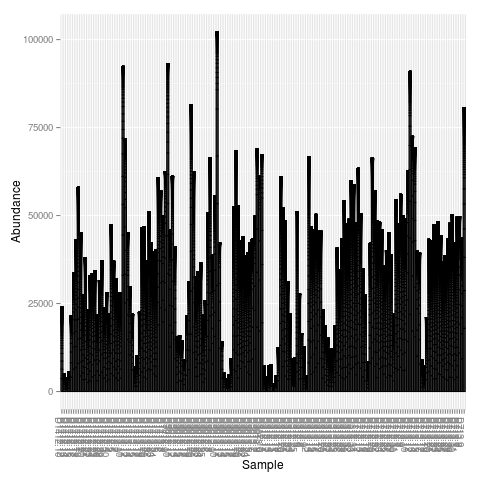

In [5]:
%%R
plot_bar(physeq.fungi)

In [6]:
%%R
sums.physeq = sample_sums(physeq.fungi)
sums.quantile = quantile(sums.physeq,  probs = c(0.1, 0.5, 1, 2, 5, 10, 50, NA)/100)
print(sums.quantile)
sums.physeq.filter = subset(sums.physeq, sum = 5360 )
head(sums.physeq)

     0.1%      0.5%        1%        2%        5%       10%       50%           
 2491.084  3451.420  3771.440  4326.120  5360.050  8948.600 40899.000        NA 
Error in subset.default(sums.physeq, sum = 5360) : 
  argument "subset" is missing, with no default
In addition: Warning message:
position_stack requires constant width: output may be incorrect
Error in subset.default(sums.physeq, sum = 5360) : 
  argument "subset" is missing, with no default


In [7]:
%%R
class(sums.physeq)
head(sums.physeq)

D1412.18  D713.15  D712.18  D3012.7 D3013.20   D712.9 
   58017    39317    42067    66408    42760    48953 


In [8]:
%%R
physeq = import_biom("data/otu_table_wtax.biom")
print(physeq)
sample.data = import_qiime_sample_data("data/Metadata_fungi.txt")
physeq = merge_phyloseq(physeq,sample.data)
print(physeq)
physeq.md = sample_data(physeq)
physeq.fungi = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))& 
                             (physeq.md$SampleID != c("D312.6")),  physeq)
physeq.fungi.prune = prune_samples(sample_sums(physeq.fungi) > 5360, physeq.fungi)
print (physeq.fungi.prune)
physeq.fungi.snorm = transform_sample_counts(physeq.fungi.prune, function(x) x/sum(x))
physeq.fungi.thresh = filter_taxa(physeq.fungi.snorm, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
#physeq.fungi.thresh.min = filter_taxa(physeq.fungi.thresh, function(x) sum(x) > 5000, TRUE)
#physeq.fungi.thresh = filter_taxa(physeq.SIP.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.fungi.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 600 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 600 taxa by 7 taxonomic ranks ]


In [11]:
%%R
head(physeq.md)

Sample Data:        [6 samples by 9 sample variables]:
         SampleID Primers       i2       i1 Day  Density Treatment Mock_Comm
D1412.18 D1412.18      14 cgtgagtg gacatagt  14 1.693620    12CCPS         N
D713.15   D713.15     135 ggatatct gatctacg   7 1.720939    13CCPS         N
D712.18   D712.18     114 actatctg tagcagct   7 1.708918    12CCPS         N
D3012.7   D3012.7      67 tagcgagt actacgac  30 1.752629    12CCPS         N
D3013.20 D3013.20     101 tcatcgag ctcgactt  30 1.692527    13CCPS         N
D712.9     D712.9     108 ctgcgtgt cgaagtat   7 1.742794    12CCPS         N
         RNA_DNA
D1412.18     DNA
D713.15      DNA
D712.18      DNA
D3012.7      DNA
D3013.20     DNA
D712.9       DNA


###Calculate Bray-Curtis distances between samples.

In [12]:
%%R
iDist <- distance(physeq.fungi.thresh, method = "bray")

### Plotting Bray-Curtis distance vs. density

In [53]:
%%R
print(head(p.nmds))

                 NMDS1        NMDS2 SampleID Primers       i2       i1 Day
D1412.18 -0.0761173247  0.016714845 D1412.18      14 cgtgagtg gacatagt  14
D713.15  -0.2272496619 -0.053833081  D713.15     135 ggatatct gatctacg   7
D712.18  -0.1110064254 -0.132987080  D712.18     114 actatctg tagcagct   7
D3012.7  -0.1811861271  0.032783043  D3012.7      67 tagcgagt actacgac  30
D3013.20  0.3471127153  0.125956735 D3013.20     101 tcatcgag ctcgactt  30
D712.9    0.0003098218 -0.008582417   D712.9     108 ctgcgtgt cgaagtat   7
          Density Treatment Mock_Comm RNA_DNA
D1412.18 1.693620    12CCPS         N     DNA
D713.15  1.720939    13CCPS         N     DNA
D712.18  1.708918    12CCPS         N     DNA
D3012.7  1.752629    12CCPS         N     DNA
D3013.20 1.692527    13CCPS         N     DNA
D712.9   1.742794    12CCPS         N     DNA


In [ ]:
%%R
p = ggplot()

###Ordinate using weighted unifrac distnaces with NMDS.

Run 0 stress 0.09429138 
Run 1 stress 0.09428954 
... New best solution
... procrustes: rmse 0.0001484351  max resid 0.001264876 
*** Solution reached

NULL


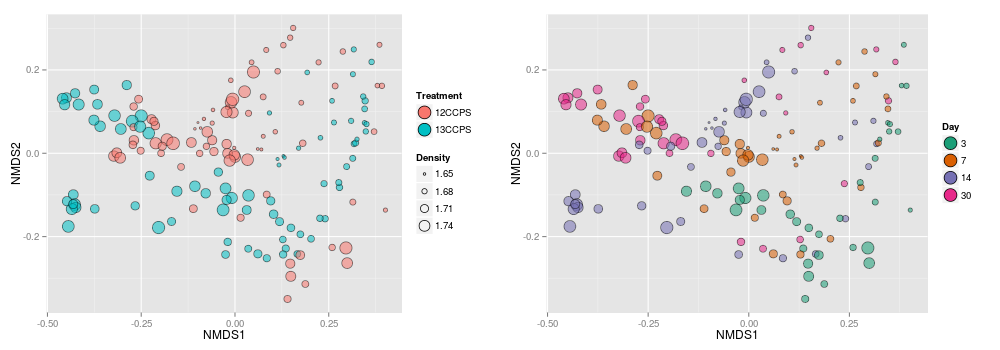

In [27]:
%%R -w 1000 -h 350
nmds = ordinate(physeq.fungi.thresh, 
                method = "NMDS", 
                distance = iDist)
p.nmds = plot_ordination(physeq.fungi.thresh, nmds, justDF = TRUE)
#print(p)

asNumeric = function(x) { as.numeric(as.character(x)) }

p1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") 
      

p2 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        scale_fill_brewer("Day", palette = "Dark2")

p.combined = grid.arrange(p1, p2, ncol=2)
print(p.combined)

In [14]:
%%R -w 1000 -h 350
pdf("figs/full_ordination.pdf", width = 12, height = 5)
grid.arrange(p1, p2, ncol=2)
dev.off()

Error in pdf("figs/full_ordination.pdf", width = 12, height = 5) : 
  cannot open file 'figs/full_ordination.pdf'


In [15]:
FileLink("figs/full_ordination.pdf")

/home/chantal/FungalSIP/figs/full_ordination.pdf

###...and the MDS figure (PC2 v Density).

NULL


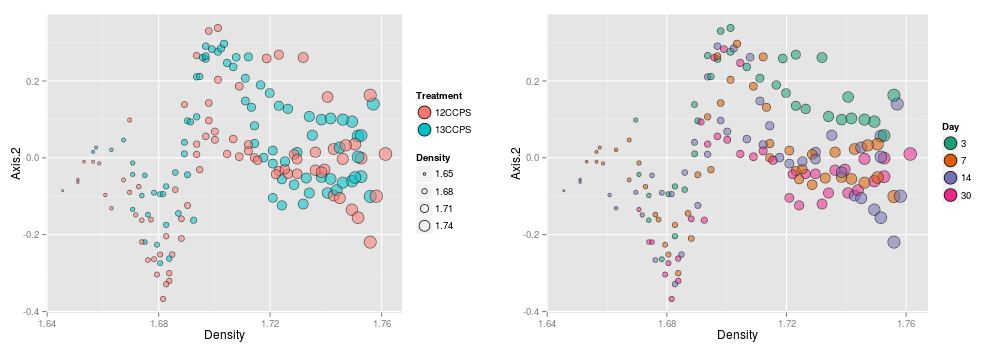

In [30]:
%%R -w 1000 -h 350
mds = ordinate(physeq.fungi.thresh, 
                method = "MDS", 
                distance = iDist)
p.mds = plot_ordination(physeq.fungi.thresh, mds, justDF = TRUE)

asNumeric = function(x) { as.numeric(as.character(x)) }

p1.mds = ggplot(p.mds, aes(x = asNumeric(Density), y = Axis.2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(x = "Density", size = "Density") 

p2.mds = ggplot(p.mds, aes(x = asNumeric(Density), y = Axis.2)) + labs(x = "Density") +
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+ 
        scale_fill_brewer("Day", palette = "Dark2")

p.combined.mds = grid.arrange(p1.mds, p2.mds, ncol=2)
print(p.combined.mds)

In [17]:
%%R -w 1000 -h 350
pdf("figs/full_ordination_density.pdf", width = 12, height = 5)
grid.arrange(p1.mds, p2.mds, ncol=2)
dev.off()

Error in pdf("figs/full_ordination_density.pdf", width = 12, height = 5) : 
  cannot open file 'figs/full_ordination_density.pdf'


In [18]:
FileLink("figs/full_ordination_density.pdf")

/home/chantal/FungalSIP/figs/full_ordination_density.pdf

# Checking different distance matrices

In [34]:
%%R
dist_methods = unlist(distance("list"))
dist_methods = dist_methods[-(1:2)]
dist_methods = dist_methods[-which(dist_methods == "ANY")]
dist_methods = dist_methods[-which(dist_methods == "morisita")]
dist_methods = dist_methods[-which(dist_methods == "mountford")]
dist_methods = dist_methods[-which(dist_methods == "dpcoa")]
print(dist_methods)

         JSD     vegdist1     vegdist2     vegdist3     vegdist4     vegdist5 
       "jsd"  "manhattan"  "euclidean"   "canberra"       "bray" "kulczynski" 
    vegdist6     vegdist7     vegdist8    vegdist10    vegdist12    vegdist13 
   "jaccard"      "gower"   "altGower"       "horn"       "raup"   "binomial" 
   vegdist14    vegdist15   betadiver1   betadiver2   betadiver3   betadiver4 
      "chao"        "cao"          "w"         "-1"          "c"         "wb" 
  betadiver5   betadiver6   betadiver7   betadiver8   betadiver9  betadiver10 
         "r"          "I"          "e"          "t"         "me"          "j" 
 betadiver11  betadiver12  betadiver13  betadiver14  betadiver15  betadiver16 
       "sor"          "m"         "-2"         "co"         "cc"          "g" 
 betadiver17  betadiver18  betadiver19  betadiver20  betadiver21  betadiver22 
        "-3"          "l"         "19"         "hk"        "rlb"        "sim" 
 betadiver23  betadiver24        dist1        dist2 

In [35]:
%%R
plist <- vector("list", length(dist_methods))
names(plist) = dist_methods
for (i in dist_methods) {
    print(i) #for debugging
    # Calculate distance matrix
        iDist <- distance(physeq.fungi.thresh, method = i)
    # Calculate ordination
    iMDS <- ordinate(physeq.fungi.thresh, "MDS", distance = iDist)
    ## Make plot Don't carry over previous plot (if error, p will be blank)
    p <- NULL
    # Create plot, store as temp variable, p
    p <- plot_ordination(physeq.fungi.thresh, iMDS, color = "treatment")
    # Add title to each plot
    p <- p + ggtitle(paste("MDS using distance method ", i, sep = ""))
    plist[[i]] = p
}

[1] "jsd"
[1] "manhattan"
[1] "euclidean"
[1] "canberra"
[1] "bray"
[1] "kulczynski"
[1] "jaccard"
[1] "gower"
[1] "altGower"
[1] "horn"
[1] "raup"
[1] "binomial"
[1] "chao"
[1] "cao"
[1] "w"
[1] "-1"
[1] "c"
[1] "wb"
[1] "r"
[1] "I"
[1] "e"
[1] "t"
[1] "me"
[1] "j"
[1] "sor"
[1] "m"
[1] "-2"
[1] "co"
[1] "cc"
[1] "g"
[1] "-3"
[1] "l"
[1] "19"
[1] "hk"
[1] "rlb"
[1] "sim"
[1] "gl"
[1] "z"
[1] "maximum"
[1] "binary"
[1] "minkowski"


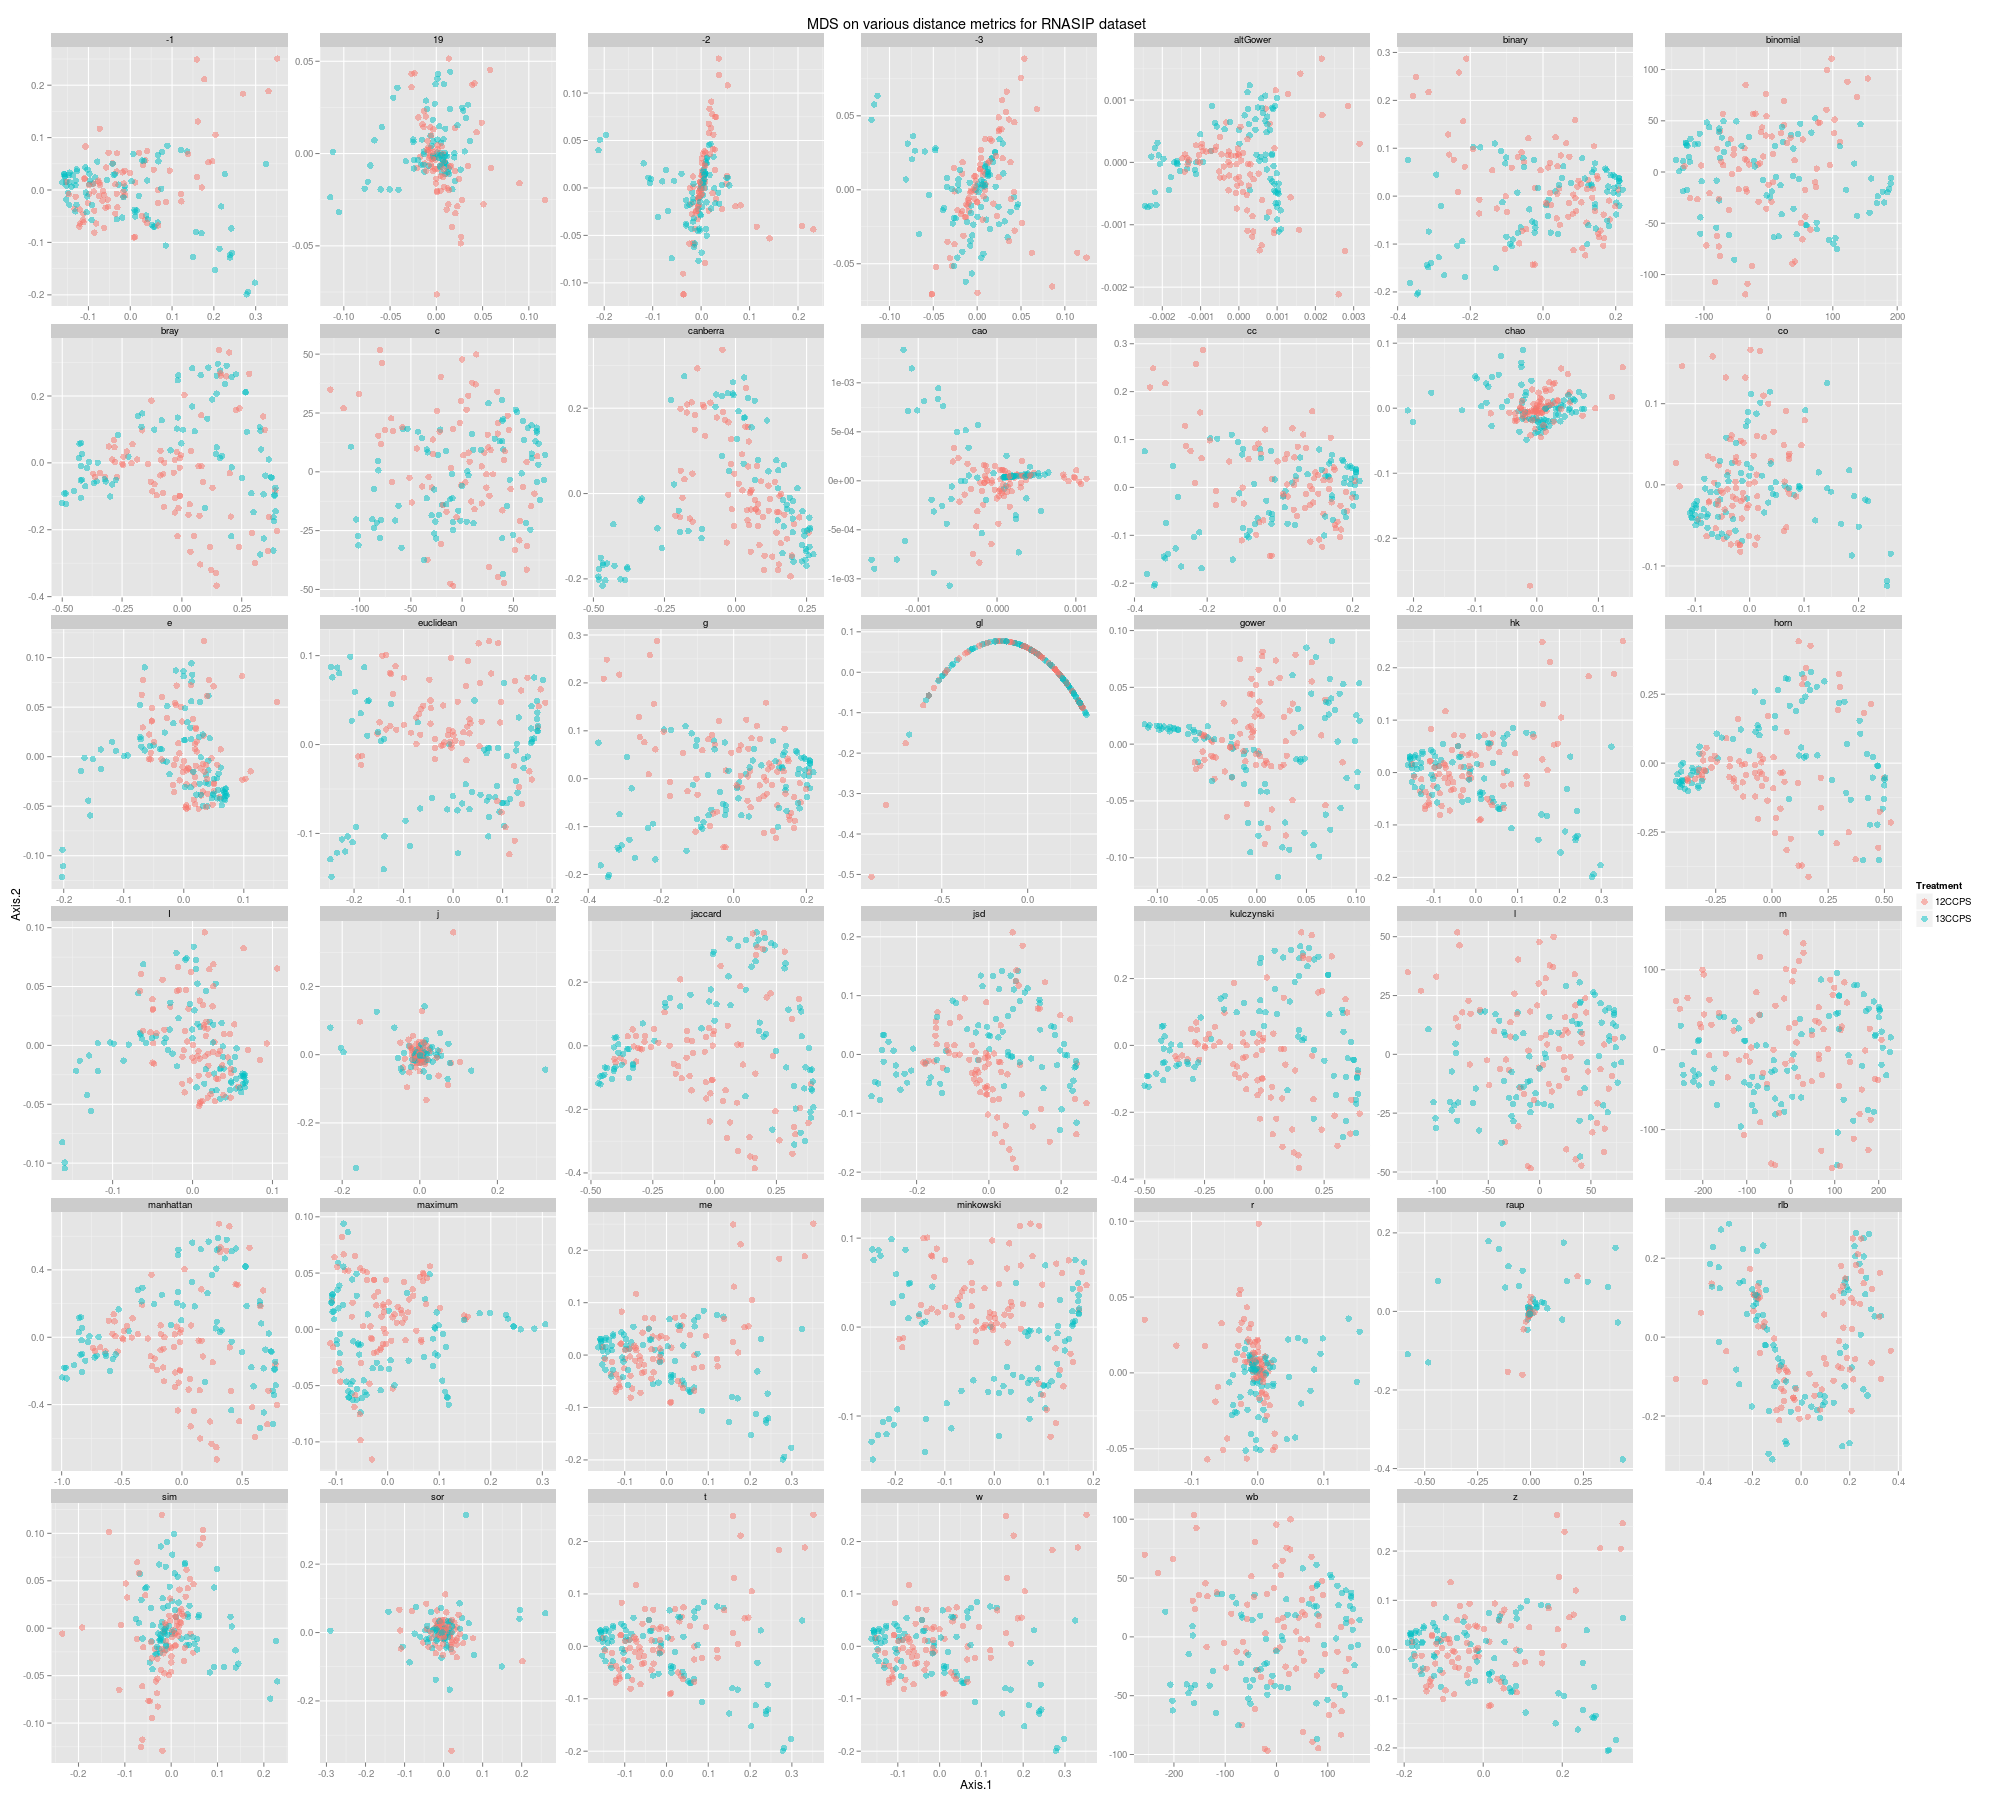

In [36]:
%%R -h 1800 -w 2000
df = ldply(plist, function(x) x$data)
names(df)[1] <- "distance"
p = ggplot(df, aes(Axis.1, Axis.2, color = Treatment))
p = p + geom_point(size = 3, alpha = 0.5)
p = p + facet_wrap(~distance, scales = "free")
p = p + ggtitle("MDS on various distance metrics for RNASIP dataset")
p_facet_dist = p
print(p)

In [22]:
FileLink("figs/dragonfly_inset_facet_grid.pdf")

/home/chantal/FungalSIP/figs/dragonfly_inset_facet_grid.pdf

NULL


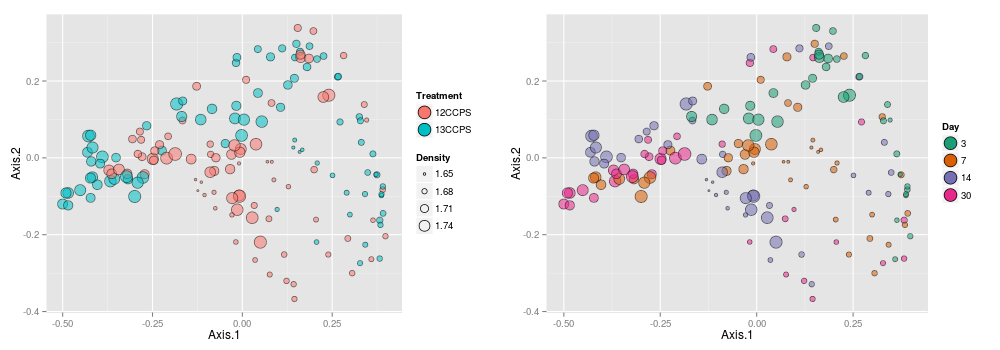

In [44]:
%%R -w 1000 -h 350
pcoa = ordinate(physeq.fungi.thresh, 
                method = "PCoA", 
                distance = "bray")
p.pcoa = plot_ordination(physeq.fungi.thresh, pcoa, justDF = TRUE)
#print(p.pcoa)

asNumeric = function(x) { as.numeric(as.character(x)) }

p1 = ggplot(p.pcoa, aes(x = Axis.1, y = Axis.2)) +  
        geom_point(aes(fill = Treatment, size = asNumeric(Density), alpha = 0.85), pch=21) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density") 

p2 = ggplot(p.pcoa, aes(x = Axis.1, y = Axis.2)) +  
        geom_point(aes(fill = factor(asNumeric(Day)), size = asNumeric(Density), alpha = 0.95), pch=21) +
        guides(alpha = FALSE, size = FALSE, fill=guide_legend(override.aes=list(size=6)))+ 
        scale_fill_brewer("Day", palette = "Dark2")

p.combined = grid.arrange(p1, p2, ncol=2)
print(p.combined)


In [45]:
%%R
registerDoParallel(cores=20)

md = sample_data(physeq.fungi.thresh)
days = unique(md$Day)
days = days[order(days)]

species.scores = function(x, y) {
    # x is the site scores data frame
    # y is the corresponding phyloseq object
    
    site.scores = x[,c(1,2)]
    
    if( setequal(row.names(site.scores), row.names(t(otu_table(y)))) ){
        w = wascores(site.scores,t(otu_table(y)),expand=TRUE)
    } else {
        print("Indices don't match")
        print(setdiff(row.names(site.scores), row.names(t(otu_table(y)))))
    }                                    

    otu.scores = data.frame(w)
    otu.scores$OTU = rownames(otu.scores)
    
    supp = tax_table(y)
    
    if( setequal(row.names(otu.scores), row.names(supp)) ){
        otu.scores.wtax = data.frame(otu.scores, supp)
    } else {
        print("Indices not the same.")
        print(setdiff(row.names(w), row.names(supp)))
    }
    
    return(otu.scores.wtax)
    
}

ord = function(x) {
    
    ps = prune_samples(md$Day == x, physeq.fungi.thresh)
    
    pcoa = ordinate(ps, 
                method = "PCoA", 
                distance = "bray")
    
    df.sites = plot_ordination(ps, pcoa, justDF = TRUE)
    df.sites$type = "sites"
    
    df.otus = species.scores(df.sites, ps)
    df.otus$Day = x
    df.otus$type = "otus"
    
    df = rbind.fill(df.otus, df.sites)
    
    return(df)
}

df.plot = ldply(days, ord)

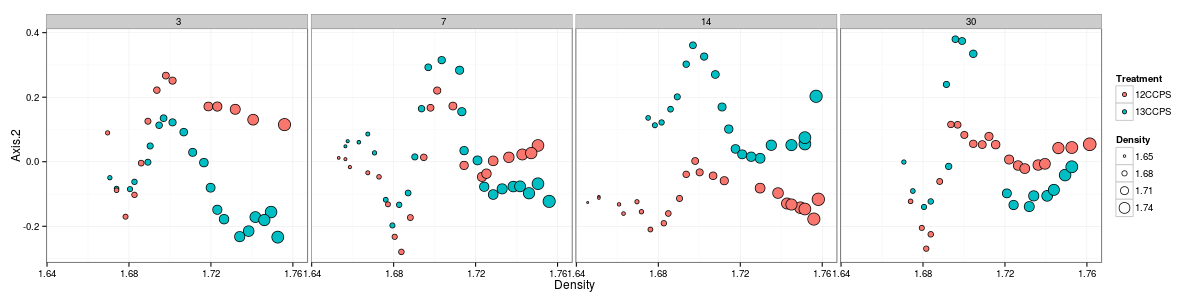

In [46]:
%%R -w 1200 -h 300

df = subset(df.plot, type == "sites")

asNum = function(x) as.numeric(as.character(x))

p = ggplot(df, aes(x =Density, y = Axis.2, size = Density, fill = Treatment))
#p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p = p + facet_wrap(~Day, nrow=1)

p = p + geom_point(shape = 21)

p = p + theme_bw()
    
p

In [ ]:
%%R -w 1200 -h 400
png("data/figs/PCoA_by_day_Density.png", width = 14, height = 4)
grid.arrange(p, ncol=1, nrow=1)
dev.off()

In [ ]:
FileLink("data/figs/PCoA_by_day_Density.png")

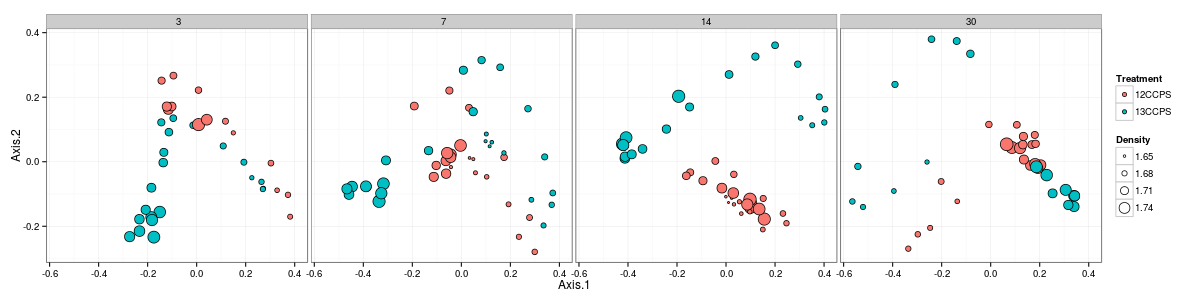

In [47]:
%%R -w 1200 -h 300
df2 = subset(df.plot, type == "sites")

asNum = function(x) as.numeric(as.character(x))

p3 = ggplot(df2, aes(x =Axis.1, y = Axis.2, size = Density, fill = Treatment))
#p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p3 = p3 + facet_wrap(~Day, nrow=1)

p3 = p3 + geom_point(shape = 21)

p3 = p3 + theme_bw()
    
p3

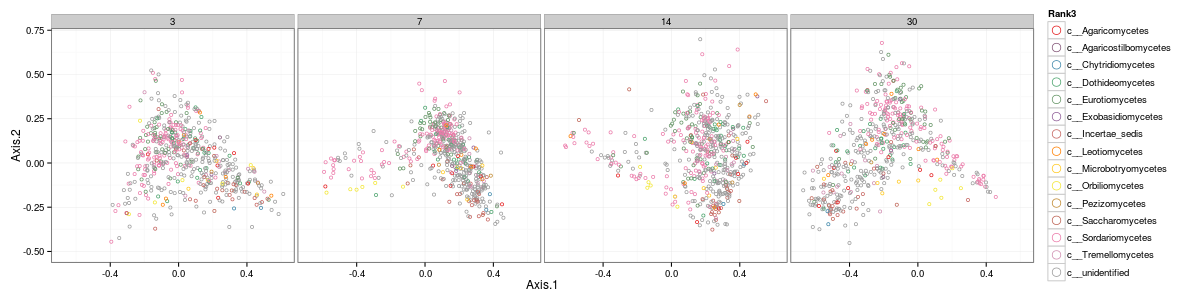

In [48]:
%%R -w 1200 -h 300

getPalette = colorRampPalette(brewer.pal(9, "Set1"))
#getPalette2= colorRampPalette(brewer.pal(8, "Dark2"))
#cmap1 = b2m.get_map("Set1", "qualitative", 9)
#cmap2 = b2m.get_map("Dark2", "qualitative", 7)
#cmap3 = b2m.get_map("Set2", "qualitative", 8)
#colors = c(getPalette,getPalette2)

p2 = ggplot(df.plot, aes(x = Axis.1, y = Axis.2, color = Rank3)) 

p2 = p2 + facet_grid(. ~ Day)

p2 = p2 + geom_point(alpha = 1, size = 1.5, shape = 21)

p2 = p2 + scale_color_manual(values=getPalette(15))

p2 = p2 + guides(color = guide_legend(override.aes = list(size = 4), label.position = "right"))

p2 = p2 + theme_bw()

p.otus = p2

p2

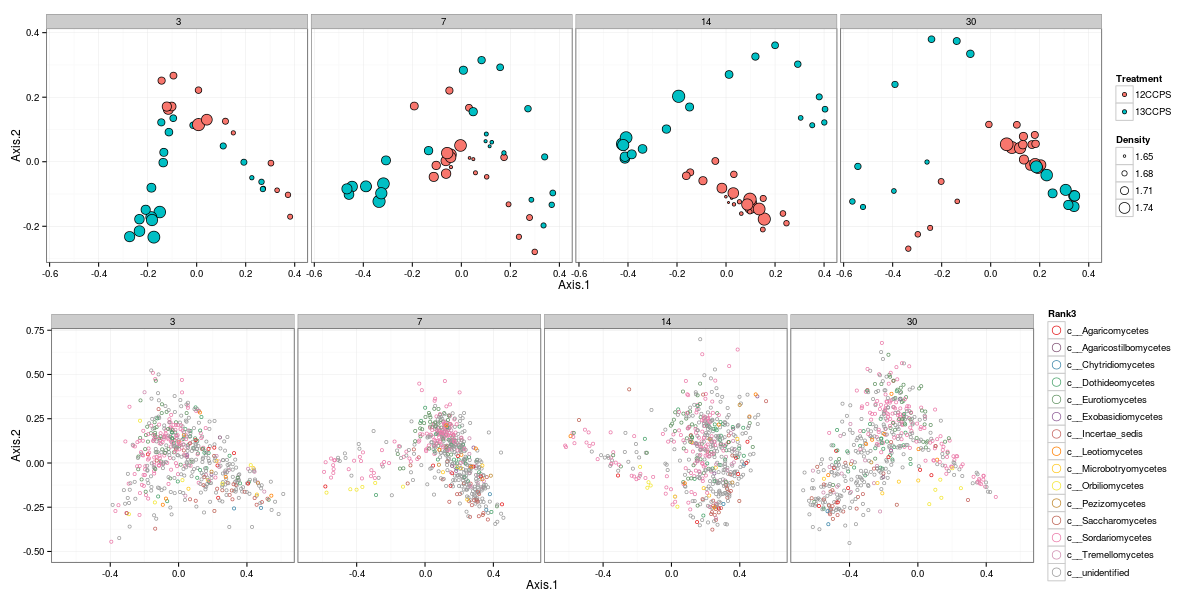

In [49]:
%%R -w 1200 -h 600

p.total = grid.arrange (p3, p2, ncol = 1, nrow = 2)


In [ ]:
%%R -w 1200 -h 800
pdf("data/figs/PCoA_by_day_OTUs.pdf", width = 14, height = 8)
grid.arrange(p3, p2, ncol=1, nrow=2)
dev.off()

In [ ]:
FileLink("data/figs/PCoA_by_day_OTUs.pdf")

Run 0 stress 0.08883458 
Run 1 stress 0.1074605 
Run 2 stress 0.1281283 
Run 3 stress 0.1074605 
Run 4 stress 0.08889257 
... procrustes: rmse 0.006956926  max resid 0.03299501 
Run 5 stress 0.08883458 
... New best solution
... procrustes: rmse 4.551744e-06  max resid 2.253358e-05 
*** Solution reached

Run 0 stress 0.06181737 
Run 1 stress 0.06040189 
... New best solution
... procrustes: rmse 0.0124586  max resid 0.05940062 
Run 2 stress 0.06040192 
... procrustes: rmse 3.636164e-05  max resid 7.447138e-05 
*** Solution reached

Run 0 stress 0.08167486 
Run 1 stress 0.1569595 
Run 2 stress 0.08166321 
... New best solution
... procrustes: rmse 0.001226489  max resid 0.005991652 
*** Solution reached

Run 0 stress 0.05866122 
Run 1 stress 0.05866121 
... New best solution
... procrustes: rmse 2.670302e-05  max resid 6.508822e-05 
*** Solution reached



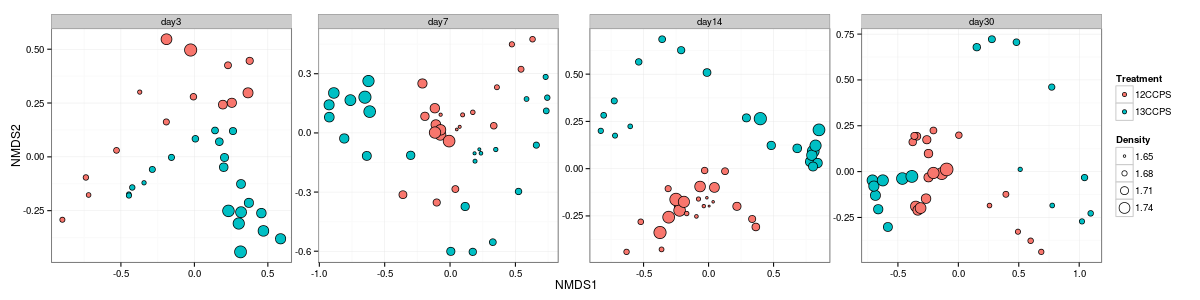

In [50]:
%%R -w 1200 -h 300

days = list(day3=3, day7=7, day14=14, day30=30)

md = sample_data(physeq.fungi.thresh)

ord = function(x) {
    ps = prune_samples((md$Day == x)&(md$SampleID != "D312.6"), physeq.fungi.thresh)
    pcoa = ordinate(ps, 
                method = "NMDS", 
                distance = "bray")
    p.pcoa = plot_ordination(ps, pcoa, justDF = TRUE)
    return(p.pcoa)
}

df = ldply(days, ord)

df$.id = factor(df$.id, levels= c("day3", "day7", "day14", "day30"))

#p = ggplot(df, aes(x = Density, y = Axis.1, size = Density, fill = Treatment))
p = ggplot(df, aes(x = NMDS1, y = NMDS2, size = Density, fill = Treatment))

p = p + facet_wrap(~.id, nrow = 1, scales = "free")

p = p + geom_point(shape = 21)

p = p + theme_bw()

p

In [51]:
%%R
d = subset(df, Day == 3)
d[order(-d$NMDS1),]

    .id        NMDS1        NMDS2 SampleID Primers       i2       i1 Day
12 day3  0.586645883 -0.380482413  D313.17     157 tcatcgag atagtacc   3
5  day3  0.469860069 -0.343845731  D313.16     156 ctgcgtgt atagtacc   3
19 day3  0.455978132 -0.261255983  D313.19     158 cgtgagtg atagtacc   3
32 day3  0.376385149  0.446152463  D312.17      57 atcgtacg cgagcgac   3
18 day3  0.371110221 -0.213587294  D313.20     159 ggatatct atagtacc   3
29 day3  0.365027956  0.297430308  D312.10      50 actatctg tagtctcc   3
8  day3  0.317774970 -0.256952050  D313.15     155 tagcgagt atagtacc   3
15 day3  0.317363288 -0.125922106  D313.21     160 gacaccgt atagtacc   3
10 day3  0.314231948 -0.441300588  D313.12     152 gacaccgt acgtgcgc   3
14 day3  0.301975693 -0.309482159  D313.14     154 actatctg atagtacc   3
21 day3  0.262721251  0.119899304  D313.25     164 ctgcgtgt gcgtatac   3
35 day3  0.254926961  0.251293798  D312.12      52 ctgcgtgt tagtctcc   3
4  day3  0.231887544 -0.250847179  D313.13     153 